In [1]:

import pandas as pd
import numpy as np
import metapack as mp
from pathlib import Path
from statsmodels.formula.api import ols
import seaborn as sns
import matplotlib.pyplot as plt
from sdipylib.plot import  source_attribution

# /Users/eric/opt/anaconda3/envs/data/lib/python3.7/site-packages/pandas/plotting/_tools.py:307: MatplotlibDeprecationWarning: 
# The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
#   layout[ax.rowNum, ax.colNum] = ax.get_visible()
import warnings
warnings.simplefilter("ignore")

large = 22; med = 16; small = 12
params = {'axes.titlesize': large,
          'legend.fontsize': med,
          'figure.figsize': (16, 10),
          'axes.labelsize': med,
          'axes.titlesize': med,
          'xtick.labelsize': med,
          'ytick.labelsize': med,
          'figure.titlesize': large}
plt.rcParams.update(params)
plt.style.use('seaborn-whitegrid')
sns.set_style("white")
%matplotlib inline

%run weights.py
%run lib.py 

source = "Survey of Consumer Finances, 2016 and 2019 pooled"



    

In [2]:


pkg = mp.multi_open('federalreserve.gov-consumer_finances-2016e2019-inherit', print_ref=True)
#pkg = mp.jupyter.open_source_package()
pkg

Opening:  index:federalreserve.gov-consumer_finances-2016e2019-inherit


# Survey of Consumer Finances, Inheritance Extract
`federalreserve.gov-consumer_finances-2016e2019-inherit-1.3.2` Last Update: 2021-01-12T05:39:48

_An Extract from the survey of consumer finances for studying networth and ineritance, from multiple years_


This is an extract of the 2016 and 2019 Survey of Consumer Finances, with extracted variables
and recoded variables oriented toward studying inheritance.


 
## Images

[![doc_img](docs/networth_race_inc.png "networth_race_inc")](docs/networth_race_inc.png)

Net Worth by Income Percentile and Race## Notes

* Version 1.2.2 Added the Inflatable flag
* Version 1.2.3 Inflated dollar ammounts to current dollars
* Version 1.2.6 Fixed inflation error, dded non-inflated dataset.
* Version 1.3.1 Added veriables for kids, vehicle assets, and others.
## Contacts

* **Wrangler** [Eric Busboom](mailto:eric@civicknowledge.com), [Civic Knowledge](http://civicknowledge.com)

## Resources

* ** [inherit_scf_16_19](data/inherit_scf_16_19.csv)**. Extract of the 2016 and 2019 SCF for inheritance and networth,uninflated
* ** [inherit_scf_16_19_i](data/inherit_scf_16_19_i.csv)**. Extract of the 2016 and 2019 SCF for inheritance and networth, inflated to 2020 dollars

## References
<ul><li> <strong>scf</string>, <em>metapack+http://library.metatab.org/federalreserve.gov-consumer_finances.csv</em>. Survey of consumer finances data packages</li><li> <strong><a href="https://fred.stlouisfed.org/graph/fredgraph.csv?&id=CPIAUCSL">cpi</a></strong>. Consumer Price Index</li><ul>

In [3]:
inherit_scf_16_19 = pkg.resource('inherit_scf_16_19').dataframe()

df =   make_descriptive_df(inherit_scf_16_19)    
dfs = df.sample(500_000, replace=True, weights=df.wt0)

In [4]:
dfs90 = dfs[dfs.nincpctle < 90]

The first, and most central fact of our analysis is that there is a very large difference between the networth of white and black households[<sup>1</sup>](#fn1). A related fact is there are many ways to measure the difference, and even more ways to adjust the data, with the result that the racial inequality of household wealth is not a single number, but a range of numbers, each of which serves a different interpretation. It is our goal to describe the range of assumptions and adjustments so people engaged in studying inequality will have a more accurate understanding of the issue. 

The most basic summary statistics for most types of data is the mean, or average. The mean networth of US black households for our dataset is $\$$152,000, while the white household average networth is over $\$$1M. However, using the mean can be misleading for data that are related to money, so the median -- the value at which 50% of households have a higher networth, and 50\$\%\$ have a lower networth, is often the preferred choice. The median networth of black households is about  $\$$20,000, while the white median networth is about $\$$190,000. Both median values are about 20% of the mean values, a very large difference. So, which value is correct?

<span id="fn1">(1)</span> Note that what we call a "household" isn't actually a household. As defined by the US Census, a household is a geoup of people who live in singe dwelling, and may consist of exgtended families or multiple famliles. In the Survey of Consumer Finances, what is called a household is actually a "Primary Exconomic Unit", which the sruvey defines as: 

    In brief, the PEU consists of an economically dominant single individual or couple (married or living as partners in a household and all other individuals in the household who are financially interdependent with that individual or couple.  For example, in the case of a household composed of a married couple who own their home, a minor child, a dependent adult child, and a financially independent parent of one of the members of the couple, the PEU would be the couple and the two children.
    
The practical implication of this definition of a household is that we will be able to assume that the households have one or two adults who control the household's finances, which will be important later when we examine wealth on a per-person basis, adjusting for household size. 
    

In [5]:
dfs.groupby(['race']).hhsize.mean()

race
black    1.350431
white    1.602824
Name: hhsize, dtype: float64

In [6]:
a = dfs.groupby('race').networth.median().to_frame('median')
c = dfs.groupby('race').networth.mean().to_frame('mean')
t = a.join(c)
display(t)
(t.loc['white']/t.loc['black']).to_frame('ratio').round(2)\
    .join((t.loc['white']-t.loc['black']).to_frame('difference').round(-3).astype(int))


,median,mean
race,,
black,18187.088608,138928.473642
white,177850.000000,952764.580575


,ratio,difference
median,9.78,160000
mean,6.86,814000


6.85795039417003


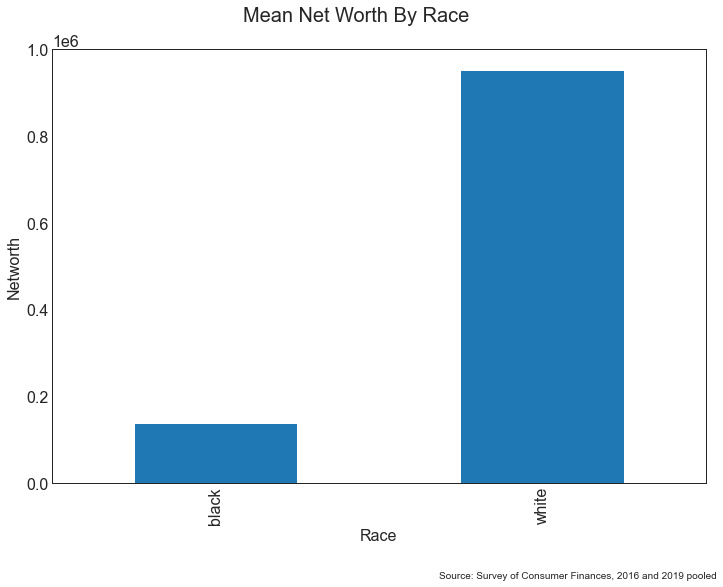

In [7]:
t = dfs.groupby('race').networth.mean()
print(t.white/t.black)
    
with new_plot('Mean Net Worth By Race', source,
             xlabel='Race', ylabel='Networth') as (fig,ax):
    
    t.plot.bar(ax=ax)

In [8]:
t = dfs.copy()
t['nw_adj'] = t.networth - t.nfin
t = t.groupby(['year','race']).nw_adj.median()

t

year  race 
2016  black   -2456.852321
      white    1127.386779
2019  black     -90.000000
      white    1100.000000
Name: nw_adj, dtype: float64

<Figure size 432x288 with 0 Axes>

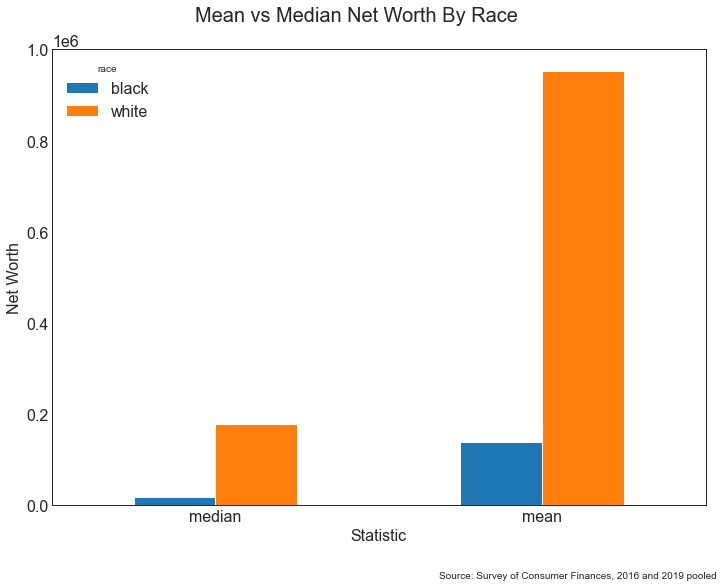

,ratio,ratio_inv,rel_a,rel_mean
median,0.102000,9.779000,0.898000,1.629000
mean,0.146000,6.858000,0.854000,1.491000
rms,0.125936,8.445739,0.876276,1.561525


In [9]:
%run ./lib.py 

with new_plot('Mean vs Median Net Worth By Race', source,
             xlabel='Statistic', ylabel='Net Worth') as (fig,ax):
    a = dfs.groupby('race').networth.median().to_frame('median')
    #b = dfs90.groupby('race').networth.mean().to_frame('mean<90%')
    c = dfs.groupby('race').networth.mean().to_frame('mean')
    
    t = a.join(c)
    
    t.T.plot.bar(ax=ax)
    plt.xticks(rotation=0) 

diffrpt(t.T)
    

If you want to show a large ratio you use the median, and if you want to show a large difference, you use the mean. 

However, when there are a small number of records in a group, the median have be very noisy, where the mean is more stable. 


year
2016    6.556824
2019    7.180345
Name: networth, dtype: float64


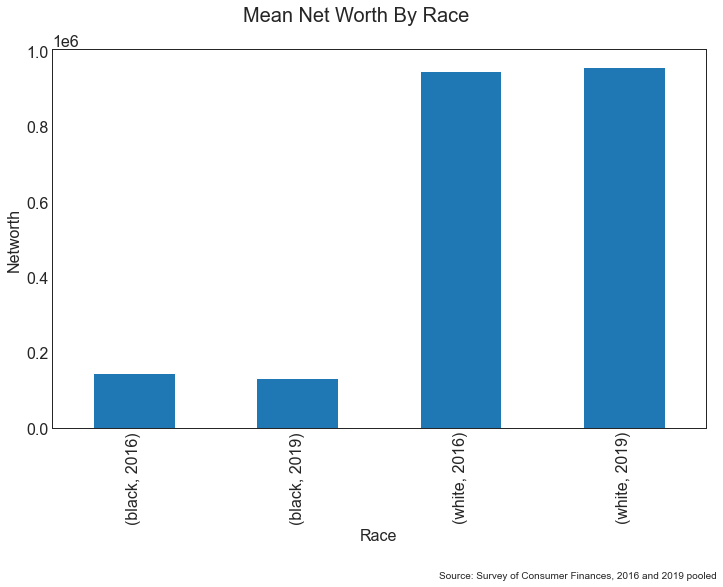

In [10]:
t = dfs.groupby(['race','year']).networth.mean()
print(t.white/t.black)
    
with new_plot('Mean Net Worth By Race', source,
             xlabel='Race', ylabel='Networth') as (fig,ax):
    
    t.plot.bar(ax=ax)

In [11]:
a = dfs.groupby('race').networth.median().to_frame('median')
c = dfs.groupby('race').networth.mean().to_frame('mean')
t = a.join(c)
(t.loc['white']/t.loc['black']).to_frame('ratio').round(2)\
    .join((t.loc['white']-t.loc['black']).to_frame('difference').round(-3).astype(int))

,ratio,difference
median,9.78,160000
mean,6.86,814000


In [12]:
a = dfs.groupby('race').networth.median().to_frame('median')
c = dfs.groupby('race').networth.mean().to_frame('mean')
t = a.join(c)
(t.loc['white']/t.loc['black']).to_frame('ratio').round(2)\
    .join((t.loc['white']-t.loc['black']).to_frame('difference').round(-3).astype(int))

,ratio,difference
median,9.78,160000
mean,6.86,814000


The reason for the difference between the median and the mean is that income is strongly skewed to the higher end. The top 1% earns a lot more money then the lower groups. 

In [13]:
a = dfs.groupby('race').networthpc.median().to_frame('median')
c = dfs.groupby('race').networthpc.mean().to_frame('mean')
t = a.join(c)
display(t)
(t.loc['white']/t.loc['black']).to_frame('ratio').round(2)\
    .join((t.loc['white']-t.loc['black']).to_frame('difference').round(-3).astype(int))

,median,mean
race,,
black,14525.00000,98945.646183
white,111834.64135,559709.070843


,ratio,difference
median,7.70,97000
mean,5.66,461000


In [14]:
dfs.nincpctle.value_counts()

70    51428
80    51211
60    51204
50    50849
40    49590
10    48677
30    48108
20    48020
0     47922
90    26880
95    20578
99     5533
Name: nincpctle, dtype: Int64

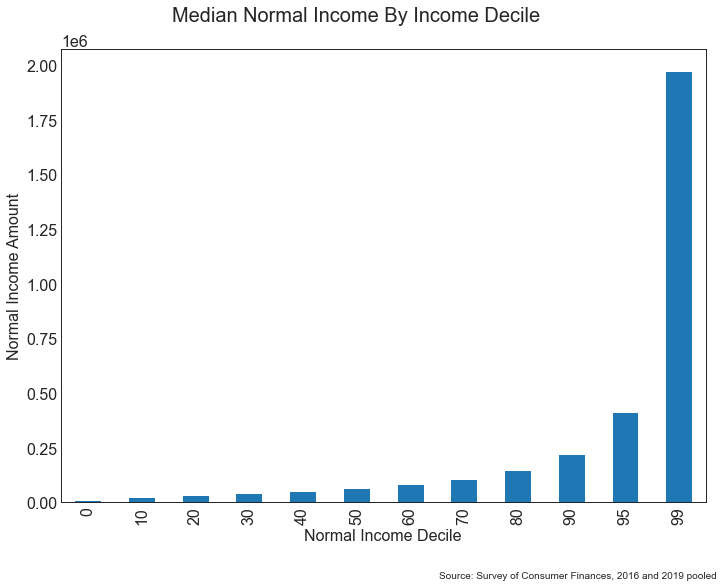

In [15]:

with new_plot('Median Normal Income By Income Decile', source,
             xlabel='Normal Income Decile', ylabel='Normal Income Amount') as (fig,ax):
    t = dfs.groupby('nincpctle').norminc.mean()
    t.plot.bar(ax=ax);


In [16]:
dfs.groupby('race').norminc.median()

race
black    40724.716063
white    67195.781504
Name: norminc, dtype: float64

In [17]:
dfs.hhsize.sum(), len(dfs)

(777714, 500000)

In [18]:
a = dfs[dfs.nincpctle>=90].networth.sum()
b = dfs[dfs.nincpctle<90].networth.sum()
a/(a+b)


0.6509584120027411

In [19]:
a = dfs[dfs.nincpctle>=99].networth.sum()
b = dfs[dfs.nincpctle<99].networth.sum()
a/(a+b)

0.3005397914293875

Wealth inequality is primarily non-racial; the top earners have a disproportionate share of the income and the wealth.

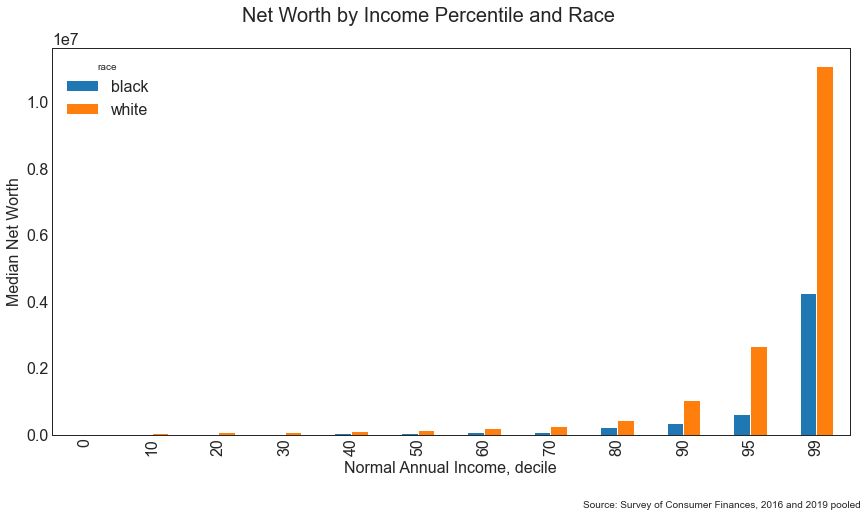

,ratio,ratio_inv,rel_a,rel_mean
0,0.1590,6.288000,0.841000,1.451000
10,0.0930,10.733000,0.907000,1.659000
20,0.1080,9.254000,0.892000,1.610000
30,0.1540,6.500000,0.846000,1.467000
40,0.3400,2.940000,0.660000,0.985000
50,0.3260,3.066000,0.674000,1.016000
60,0.4240,2.357000,0.576000,0.808000
70,0.3680,2.717000,0.632000,0.924000
80,0.5480,1.825000,0.452000,0.584000
90,0.3350,2.985000,0.665000,0.996000


In [20]:
with new_plot('Net Worth by Income Percentile and Race', source, figsize=(12,7),
             xlabel='Normal Annual Income, decile', ylabel='Median Net Worth') as (fig,ax):
    t = dfs.groupby(['nincpctle', 'race']).networth.median().unstack()
    t.plot.bar(ax=ax)

diffrpt(t)

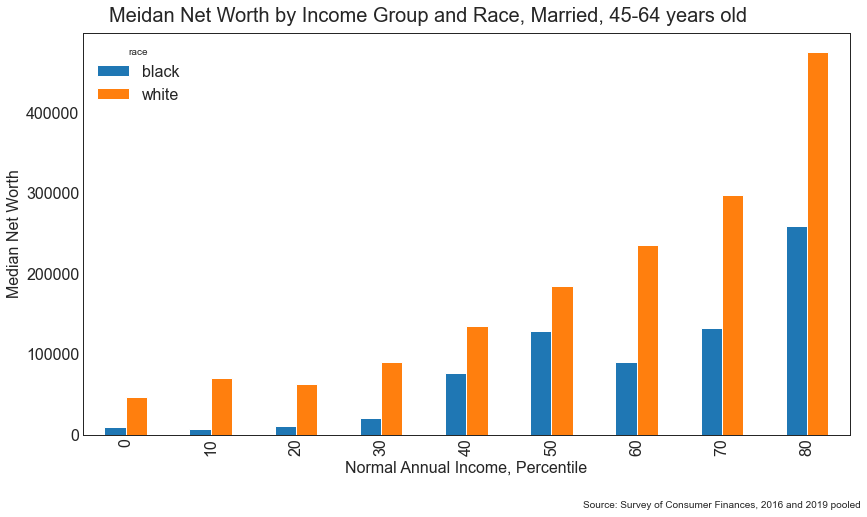

,ratio,ratio_inv,rel_a,rel_mean
0,0.196000,5.101000,0.804000,1.344000
10,0.103000,9.739000,0.897000,1.628000
20,0.170000,5.872000,0.830000,1.418000
30,0.229000,4.364000,0.771000,1.254000
40,0.564000,1.775000,0.436000,0.558000
50,0.695000,1.438000,0.305000,0.360000
60,0.381000,2.622000,0.619000,0.896000
70,0.446000,2.241000,0.554000,0.766000
80,0.546000,1.830000,0.454000,0.587000
rms,0.418155,4.653046,0.659434,1.065367


In [21]:
with new_plot('Meidan Net Worth by Income Group and Race, Married, 45-64 years old', 
              source, figsize=(12,7),
             xlabel='Normal Annual Income, Percentile', ylabel='Median Net Worth') as (fig,ax):
    t = dfs90
    t = t[(t.hhsize == 2) & (t.agecl.isin(['45-54','55-64']))  ]

    t = t.groupby(['nincpctle', 'race']).networth.median().unstack()
    t.plot.bar(ax=ax)
    
diffrpt(t)

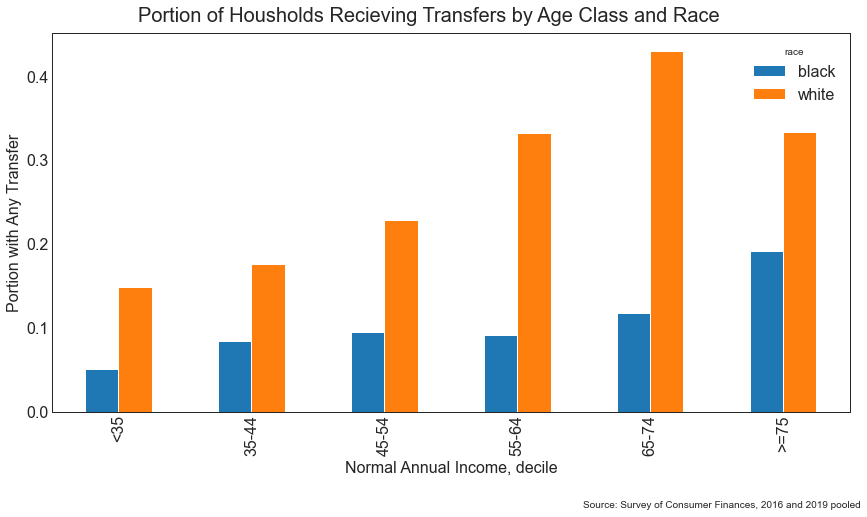

,ratio,ratio_inv,rel_a,rel_mean
<35,0.344000,2.908000,0.656000,0.977000
35-44,0.476000,2.103000,0.524000,0.711000
45-54,0.412000,2.428000,0.588000,0.833000
55-64,0.274000,3.648000,0.726000,1.139000
65-74,0.272000,3.673000,0.728000,1.144000
>=75,0.572000,1.749000,0.428000,0.545000
rms,0.406387,2.846989,0.617913,0.918061


In [22]:
with new_plot('Portion of Housholds Recieving Transfers by Age Class and Race',
              source, figsize=(12,7),
             xlabel='Normal Annual Income, decile', ylabel='Portion with Any Transfer') as (fig,ax):
    
    t = dfs.groupby(['agecl','race']).any_transfer.mean().unstack()
    t.plot.bar(ax=ax)
    
diffrpt(t)


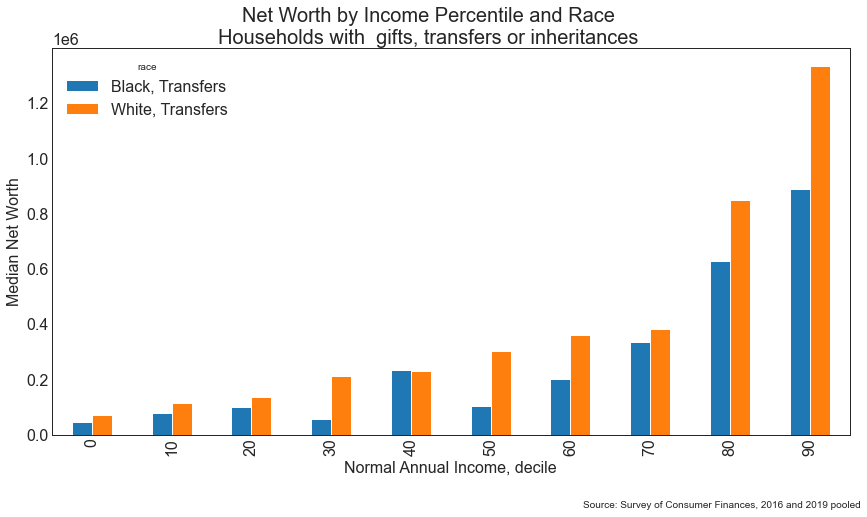

,ratio,ratio_inv,rel_a,rel_mean
0,0.649000,1.540000,0.351000,0.42500
10,0.702000,1.425000,0.298000,0.35000
20,0.716000,1.398000,0.284000,0.33200
30,0.261000,3.835000,0.739000,1.17300
40,1.010000,0.990000,0.010000,0.01000
50,0.341000,2.933000,0.659000,0.98300
60,0.564000,1.772000,0.436000,0.55700
70,0.871000,1.147000,0.129000,0.13700
80,0.742000,1.347000,0.258000,0.29600
90,0.666000,1.501000,0.334000,0.40100


In [23]:
with new_plot('Net Worth by Income Percentile and Race\nHouseholds with  gifts, transfers or inheritances',
              source, figsize=(12,7),
             xlabel='Normal Annual Income, decile', ylabel='Median Net Worth') as (fig,ax):
    
    nh = dfs[dfs.gi_sum == 0]  # "no help"
    yh = dfs[dfs.gi_sum != 0] # " Yes help"
    
    t = yh[yh.nincpctle<95].groupby(['nincpctle','race']).networth.median().unstack()

    t.rename(columns={'white':'White, Transfers', 'black':'Black, Transfers'}).plot.bar(ax=ax)
    
diffrpt(t)

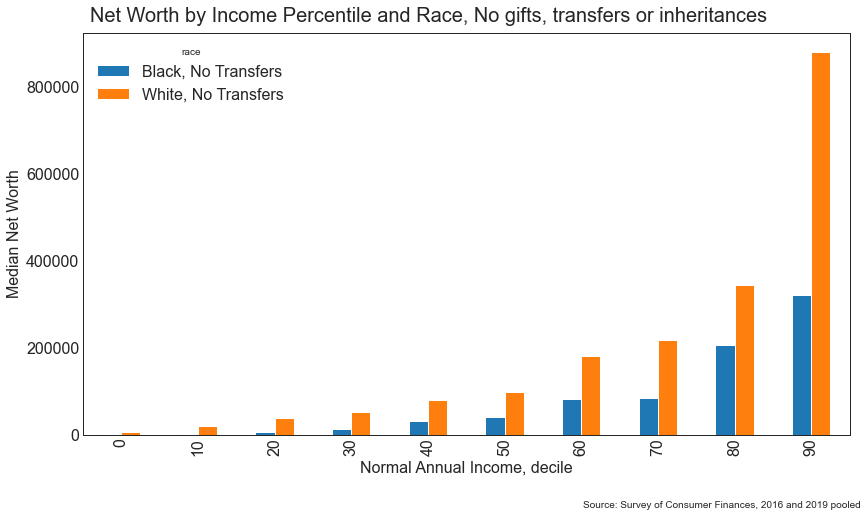

,ratio,ratio_inv,rel_a,rel_mean
0,0.207000,4.821000,0.793000,1.313000
10,0.129000,7.772000,0.871000,1.544000
20,0.147000,6.799000,0.853000,1.487000
30,0.237000,4.219000,0.763000,1.234000
40,0.389000,2.568000,0.611000,0.879000
50,0.409000,2.446000,0.591000,0.839000
60,0.449000,2.229000,0.551000,0.761000
70,0.381000,2.622000,0.619000,0.896000
80,0.600000,1.667000,0.400000,0.500000
90,0.364000,2.748000,0.636000,0.933000


In [24]:
with new_plot('Net Worth by Income Percentile and Race, No gifts, transfers or inheritances',
              source, figsize=(12,7),
             xlabel='Normal Annual Income, decile', ylabel='Median Net Worth') as (fig,ax):
    
    nh = dfs[dfs.gi_sum == 0]  # "no help"
    yh = dfs[dfs.gi_sum != 0] # " Yes help"
    
    t = nh[nh.nincpctle<95].groupby(['nincpctle','race']).networth.median().unstack()

    t.rename(columns={'white':'White, No Transfers', 'black':'Black, No Transfers'}).plot.bar(ax=ax)

diffrpt(t)

,ratio,ratio_inv,rel_a,rel_mean
No HS,0.260000,3.843000,0.740000,1.174000
HS/GED,0.684000,1.462000,0.316000,0.375000
Some College,0.340000,2.943000,0.660000,0.985000
College,0.672000,1.488000,0.328000,0.392000
rms,0.525033,2.635407,0.545582,0.812833


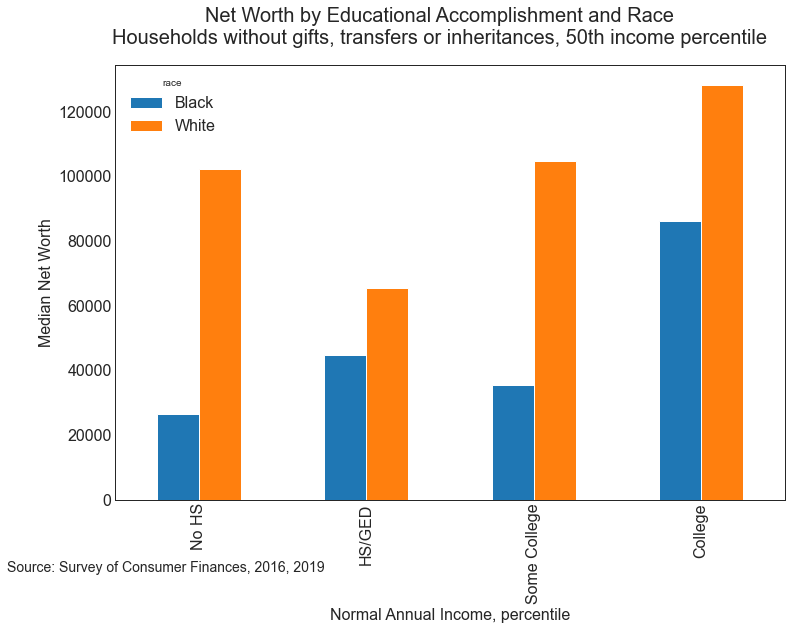

In [25]:
fig, ax = plt.subplots(figsize=(12,8))

fig.suptitle('Net Worth by Educational Accomplishment and Race\nHouseholds without '
             'gifts, transfers or inheritances, 50th income percentile', fontsize=20)
t = dfs90[ (dfs90.nincpctle == 60) & (dfs90.gi_sum == 0) ]
t = t.groupby(['edcl','race']).networthpc.median().unstack()

display(diffrpt(t))

t = t.rename(columns={'white':'White', 'black':'Black'})
t.plot.bar(ax=ax)
plt.gcf().text(0,0, f"Source: Survey of Consumer Finances, 2016, 2019", fontsize=14) 
ax.set_xlabel('Normal Annual Income, percentile')
ax.set_ylabel('Median Net Worth');



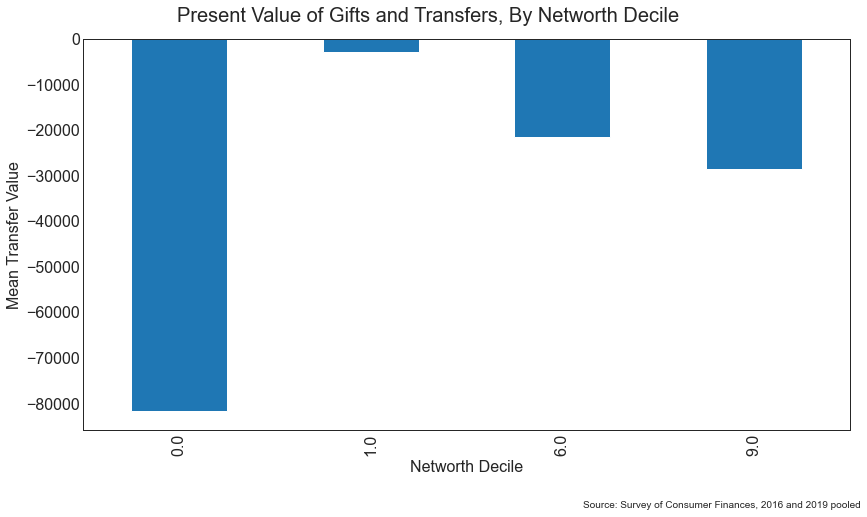

In [26]:

with new_plot('Present Value of Gifts and Transfers, By Networth Decile', source, figsize=(12,7),
             xlabel='Networth Decile', ylabel='Mean Transfer Value') as (fig,ax):
    t = dfs[(dfs.hhsize == 2) & 
            (dfs.agecl.isin(['45-54','55-64'])) &
            (dfs.edcl=='College') &
            (dfs.nincpctle<95) & 
            (dfs.nwpctlecat<10)]
    #t.groupby('nwpctle').gi_value_cd.mean().plot.bar(ax=ax)
    t.groupby('gi_value_cd_decile').networth.mean().plot.bar(ax=ax)


,networth_pctle,gi_value_cd_pctle
networth_pctle,1.00000,0.36818
gi_value_cd_pctle,0.36818,1.00000


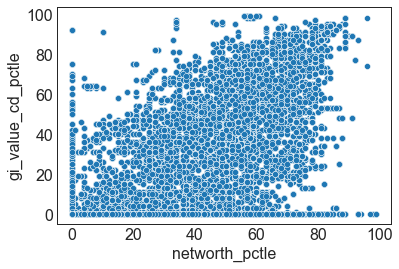

In [27]:
sns.scatterplot(data=dfs90, x='networth_pctle', y='gi_value_cd_pctle');

t=dfs[['networth_pctle','gi_value_cd_pctle']].dropna()
t.corr()

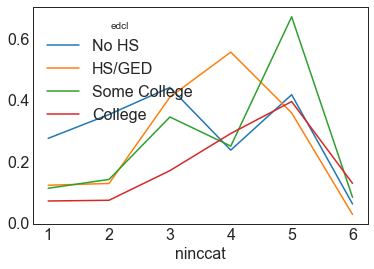

In [28]:
t = df.groupby(['ninccat','edcl','race']).networth.median().unstack()
t = t.black/t.white
t.unstack().plot()

# Role of Stocks and Home Equity

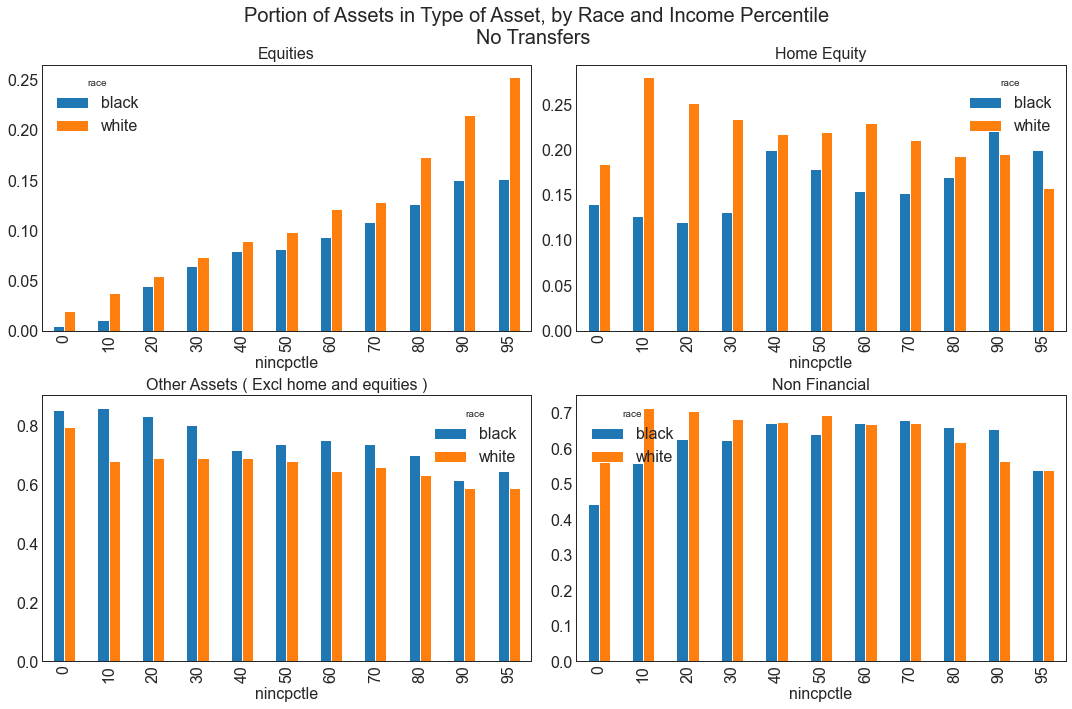

In [29]:
t = dfs[dfs.n_transfer==0].copy()
t['house_r'] = t.homeeq/t.asset
t['eq_r'] = t.equity/t.asset
t['other_r'] = (t.asset-t.equity-t.homeeq)/t.asset
t['nfin_r'] = t.nfin/t.asset
t[['asset','networth','house_r', 'eq_r','other_r', 'nfin_r']].corr()

fig, ax = plt.subplots(2,2, figsize=(15,10))
ax = list(ax.flat)

g = t[t.nincpctle<99].groupby(['race','nincpctle'])

g.eq_r.mean().unstack().T.plot.bar(ax=ax[0]); ax[0].set_title('Equities', fontsize=16)
g.house_r.mean().unstack().T.plot.bar(ax=ax[1]); ax[1].set_title('Home Equity', fontsize=16)
g.other_r.mean().unstack().T.plot.bar(ax=ax[2]); ax[2].set_title('Other Assets ( Excl home and equities )', fontsize=16)
g.nfin_r.mean().unstack().T.plot.bar(ax=ax[3]); ax[3].set_title('Non Financial', fontsize=16)
fig.suptitle("Portion of Assets in Type of Asset, by Race and Income Percentile\nNo Transfers ", fontsize=20)

plt.tight_layout()
plt.subplots_adjust(top=0.90)

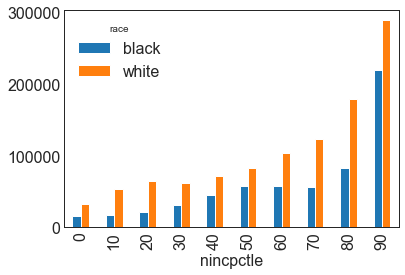

In [30]:
t = nh.copy()
t['he_nfin_r'] = (t.homeeq+t.equity)/ (t.homeeq+t.equity+t.nfin)
g = t[t.nincpctle<95].groupby(['race','nincpctle'])
g.homeeq.mean().unstack().T.plot.bar()

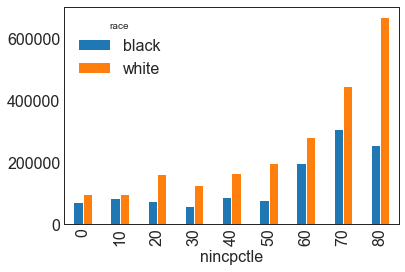

In [31]:
t = nh.copy()
t = t[ (t.nincpctle < 90) & (t.homeeq > 0) & (t.gi_sum == 0) & (t.married==2)]
g = t[t.nincpctle<95].groupby(['race','nincpctle'])
t = g.networth.median().unstack().T
t.plot.bar()

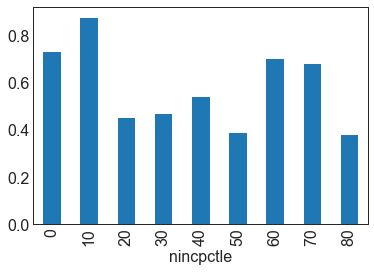

In [32]:
(t.black/t.white).plot.bar()

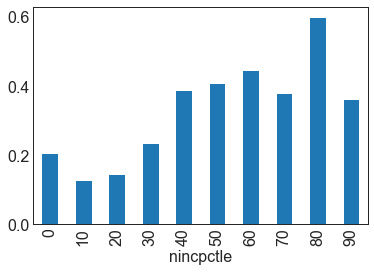

In [33]:
t = nh.copy()
#t = t[ (t.nincpctle < 90) & (t.homeeq > 0) & (t.gi_sum == 0) & (t.married==2)]
g = t[t.nincpctle<95].groupby(['race','nincpctle'])
t = g.networth.median().unstack().T

(t.black/t.white).plot.bar()

In [34]:
t = dfs[dfs.age_1 <45].groupby(['nincpctle','race']).any_transfer.mean().unstack() 
t

race,black,white
nincpctle,,
0,0.020376,0.115837
10,0.045695,0.173239
20,0.032216,0.135912
30,0.065583,0.119614
40,0.135582,0.151053
50,0.119431,0.155305
60,0.040029,0.188857
70,0.085008,0.190149
80,0.018195,0.147974


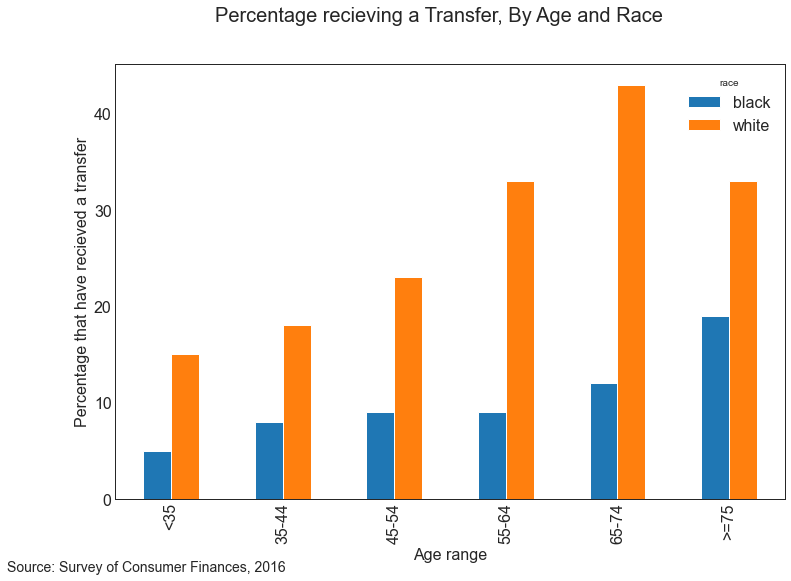

In [35]:
fig, ax = plt.subplots(figsize=(12,8))

fig.suptitle('Percentage recieving a Transfer, By Age and Race', fontsize=20)

t = (dfs.groupby(['race', 'agecl']).any_transfer.mean()*100).round(0).unstack().T

t.plot.bar(ax=ax)
plt.gcf().text(0,0, f"Source: Survey of Consumer Finances, 2016", fontsize=14) 
ax.set_xlabel('Age range')
ax.set_ylabel('Percentage that have recieved a transfer');



In [36]:
t = dfs[(dfs.networth > 0) & (dfs.networth_pctle < 90) & (dfs.n_transfer > 0)]
s =(t.gi_value_cd/t.networth).replace(np.inf,np.nan)
s.groupby(t.race).describe()

,count,mean,std,min,25%,50%,75%,max
race,,,,,,,,
black,8283.0,1.066513,1.679118,0.001569,0.243556,0.564920,1.108842,11.810280
white,106747.0,6.268764,224.386143,-0.000004,0.085367,0.253357,0.732066,11148.903958


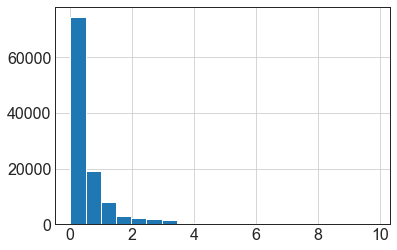

In [37]:
(s[(s > 0) & (s<10)]).hist(bins=20)

In [38]:


dfs.groupby('race').case_id.count() / len(dfs)

race
black    0.187786
white    0.812214
Name: case_id, dtype: float64

In [39]:
inherit_scf_16_19 = pkg.resource('inherit_scf_16_19').dataframe()
dfi = inherit_scf_16_19.sample(1_000_000, replace=True, weights=inherit_scf_16_19.wt0)
dfi.groupby('race').case_id.count() / len(dfi)

race
black    0.157973
hisp     0.111143
other    0.050968
white    0.679916
Name: case_id, dtype: float64

In [40]:
dfi.groupby('race').norminc.median()

race
black    40724.716063
hisp     43091.601936
other    73255.723292
white    67195.781504
Name: norminc, dtype: float64

# Share of Wealth of the Wealthy

In [41]:
# What portions of wealth are held by those above and below $1M in networth?
t = df[(df.year == 2019) ].sort_values('networth')

min_idx = np.abs(t.networth-1e6).argmin()+1

# Row label of the first record with networth over $1M
min_label = t.iloc[min_idx].name

t.loc[:min_label,'nw_class']  = 'lt1m'
t.loc[min_label:,'nw_class']  = 'gt1m'

t['w_networth'] = t.networth * t.wt0
t['w_asset'] = t.asset * t.wt0

t.groupby('nw_class').w_networth.sum()/t.w_networth.sum()


nw_class
gt1m    0.797863
lt1m    0.202137
Name: w_networth, dtype: float64

In [42]:
t.groupby('nw_class').w_asset.sum()/t.w_asset.sum()


nw_class
gt1m    0.739979
lt1m    0.260021
Name: w_asset, dtype: float64

In [43]:
t.groupby('nw_class').apply(wmedian, 'norminc')

nw_class
gt1m    202605.462412
lt1m     53960.248783
dtype: float64